In [1]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import os
import pandas as pd
from datetime import date
import matplotlib as mpl
from matplotlib import pyplot as plt

from utils.basic_utils import csv_store, csv_ext, numeric_cols
from utils.pricing import dummy_col, px_fwd_ret, get_ind_index, discret_rets
from utils.pricing import rename_col
from utils.fundamental import chain_outlier
from utils.TechnicalDS import TechnicalDS

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

Loading utils/config.json


Using TensorFlow backend.


In [2]:
pd.options.display.float_format = '{:,.3f}'.format
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = [5.0, 3.0]
mpl.rcParams['font.size'] = 8
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'large'

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

#### Context data

In [4]:
# context
context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'px_vol_ds': 'universe-px-vol-ds.h5',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252*15,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 300, #850
    'max_iter': 10, #50
    'l2_reg': 0.01,
}

In [5]:
# get latest pricing file from inferece instance
px_vol_ds = context['px_vol_ds']
tmp_path = context['tmp_path']
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@35.162.96.235:~/inception/tmp/{px_vol_ds} {tmp_path}{px_vol_ds}

universe-px-vol-ds.h5                         100%  228MB   2.1MB/s   01:49    


In [8]:
tech_ds = TechnicalDS(
    context['tmp_path'], 
    context['px_vol_ds'], 
    load_ds=True, 
    look_ahead=context['look_ahead'], 
    max_draw_on=True, 
    tickers='All',
)
y_col = tech_ds.ycol_name

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4673 entries, 2004-06-02 to 2019-06-03
Columns: 6380 entries, (high, 0700.HK) to (volume, ^VIX)
dtypes: float32(6380)
memory usage: 113.8 MB
None
Target date: 2019-06-03
Loading file quote/csv/2019-06-03
Loading file summary-categories/assetProfile
1199 companies
Universe sectors: 11, industries: 136


In [9]:
quotes = tech_ds.quotes
profile = tech_ds.profile
liquid_tickers = list(quotes.loc[
    (quotes.quoteType == 'EQUITY') &
    (quotes.regularMarketPrice > 20) & 
    (quotes.averageDailyVolume3Month > 0.3e6) 
    , 'symbol'])
tech_ds.tickers = liquid_tickers
# quotes.loc[quotes.regularMarketPrice < 50, 'regularMarketPrice'].hist(bins=50)
# quotes.loc[quotes.v < 50, 'regularMarketPrice']
# quotes.loc[quotes.averageDailyVolume3Month > 0.3e6, 'averageDailyVolume3Month'].hist(bins=50)

clean_px, labels = tech_ds.clean_px, tech_ds.forward_return_labels

#### Predict

In [654]:
def pre_process_ds(context):
    raw_df = tech_ds.stitch_companies_groups()
    print(f'Shape excluding NAs: {raw_df.shape}')
    symbols = raw_df.reset_index().set_index(['symbol']).index
    sector_map = tech_ds.profile.loc[tech_ds.tickers,'sector'].to_dict()
    raw_df.loc[:, 'sector'] = symbols.map(sector_map)
    raw_df = chain_outlier(raw_df, None)
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(raw_df)
    if scale_on: raw_df.loc[:, num_cols] = scaler.fit_transform(
        raw_df[num_cols])
    # add categoricals
    raw_df.dropna(subset=['sector'], inplace=True)
    raw_df = dummy_col(raw_df, 'sector', shorten=True)
    return raw_df

In [655]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']

    joined_df = pre_process_ds(context)
    joined_df.reset_index(level=1, inplace=True)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    # save feature order
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True)
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols:
            pred_X[c] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])

    labels = tech_ds.forward_return_labels
    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: labels[x], preds_classes))
    probs = np.round(preds, 3)
    # higest prob
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs]
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=labels)
    pred_df = pd.concat([pred_df, prob_df[labels]], axis=1)
    pred_df.index.name = 'pred_date'

#     # store in S3
#     s3_path = context['s3_path']
#     s3_df = pred_df.reset_index(drop=False)
#     rename_col(s3_df, 'index', 'pred_date')
#     csv_store(s3_df, s3_path, csv_ext.format(tech_ds.tgt_date))

    return pred_df

In [656]:
%%time 
# predict for all
pred_df = predict_ds(context)

OCLHV dataframes
Inverting instruments
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Max draw/pull dataframes
Ranked returns dataframes
Forward return dataframe
Group index
Group percentage changes
Group pct stds
Group performance deltas
% above MA by group
% positive / negative chg stds by group
Group 50 day stds
Group 50 day deltas
Ranked returns dataframes
Dataset columns: Index(['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'IntraDayChg',
       'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH', 'Pct52WL', 'PctVol10DA',
       'PctVol50DA', 'PctDV10DA', 'PctDV50DA', 'RollRealVol30', 'PctChgStds1',
       'PctChgStds20', 'PctChgStds50', 'PctChgStds200', 'MaxDraw120',
       'MaxPull120', 'PerfRank20', 'PerfRank50', 'PerfRank200', 'fwdRet120',
       '50StdsAll', '50StdsSect', '50StdsInd', '200StdsAll', '200StdsSect',
       '200StdsInd', 'pctGt50MAAll', 'pctGt50MASect', 'pctGt

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


pred_X.shape (3308921, 70)
pred_X.shape (3308921, 69)
Loaded ../ML/micro_TF.h5
Saved recommend/micro_ML/2019-05-28.csv
CPU times: user 1h 10min 8s, sys: 1h 44min, total: 2h 54min 9s
Wall time: 22min 28s


#### Load saved

In [657]:
pred_df.to_hdf(tmp_path + 'micro_pred.h5', key='micro_pred')

In [31]:
pred_df = pd.read_hdf(tmp_path + 'micro_pred.h5')
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3308921 entries, 2004-06-01 to 2019-05-28
Data columns (total 9 columns):
symbol        object
pred_class    int64
pred_label    object
confidence    float64
bear          float32
short         float32
neutral       float32
long          float32
bull          float32
dtypes: float32(5), float64(1), int64(1), object(2)
memory usage: 189.3+ MB


In [10]:
%%time
# read from S3
from utils.basic_utils import csv_load
s3_path = context['s3_path']
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{tech_ds.tgt_date}'), 
    index_col='pred_date', parse_dates=True)
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103920 entries, 2018-12-10 to 2019-06-03
Data columns (total 9 columns):
symbol        103920 non-null object
pred_class    103920 non-null int64
pred_label    103920 non-null object
confidence    102529 non-null float64
bear          102529 non-null float64
short         102529 non-null float64
neutral       102529 non-null float64
long          102529 non-null float64
bull          102529 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 7.9+ MB
CPU times: user 229 ms, sys: 126 ms, total: 356 ms
Wall time: 8.28 s


In [11]:
pred_df.tail()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-06-03,ZBH,0,bear,0.767,0.767,0.002,0.008,0.011,0.212
2019-06-03,ZBRA,0,bear,0.919,0.919,0.016,0.030,0.011,0.025
2019-06-03,ZEN,4,bull,0.821,0.138,0.001,0.004,0.036,0.821
2019-06-03,ZION,4,bull,0.584,0.070,0.117,0.189,0.040,0.584
2019-06-03,ZTS,4,bull,0.788,0.034,0.013,0.074,0.091,0.788


#### Visualize one company

In [13]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


bear      0.458
bull      0.371
neutral   0.155
short     0.010
long      0.007
Name: pred_label, dtype: float64

In [14]:
symbol = np.random.choice(tech_ds.tickers)
# symbol = 'EXEL'
print(f'Active symbol: {symbol}\n first five elements: {tech_ds.tickers[:5]}')

Active symbol: MOH
 first five elements: ['0700.HK', '3690.HK', '9984.T', 'A', 'AAL']


In [15]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df, labels):
    
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    look_ahead = context['look_ahead']
    pct_chg_df = px_df.pct_change(look_ahead)
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)
    
    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
#         figsize=(10, 2), 
        grid=True,
        rot=0,
        ax=axes[0])

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
#         figsize=(10, 3), 
        secondary_y='pred_class',
        rot=0,
        ax=axes[1])

    # probability distribution
    co_pred[labels].plot.area(
        title=f'{pred_symbol} Prediction probabilities', 
#         figsize=(10, 2), 
        ylim=(0, 1), 
        cmap='RdYlGn', 
        rot=0,
        ax=axes[2])

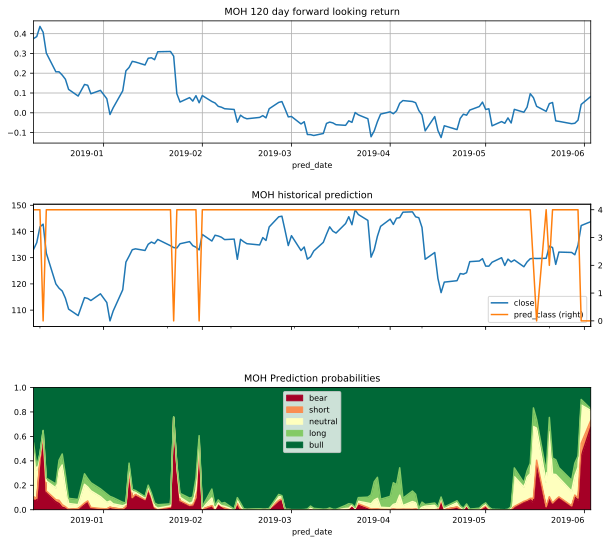

In [16]:
plot_symbol_hist_pred(symbol, clean_px, context, pred_df, labels)

In [17]:
pred_df.loc[pred_df.symbol.isin([symbol])].tail()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-05-28,MOH,4,bull,0.758,0.028,0.004,0.119,0.090,0.758
2019-05-29,MOH,4,bull,0.621,0.109,0.011,0.157,0.103,0.621
2019-05-30,MOH,4,bull,0.561,0.075,0.021,0.252,0.091,0.561
2019-05-31,MOH,0,bear,0.438,0.438,0.105,0.314,0.045,0.098
2019-06-03,MOH,0,bear,0.673,0.673,0.057,0.082,0.013,0.176


### AI driven portfolio construction

In [76]:
# Key inputs
long = False # enable long or short
loss_protection = False # stop losses dont seem to help
max_loss = 0.1
holding_period = 120 # how many days to hold / rebalance
as_of_date = -holding_period
as_of_date = -1
watch_overtime = False # pick most frequent predictions within X study period
study_period = -10;
min_confidence = 0.95 # cut off
period_tresh = 0.5 # percent of time in the list during study period
nbr_positions = 10
pred_classes = [3, 4] if long else [0, 1]
# pred_classes = [0, 1, 2, 3, 4] # all classes, is it a good picker?

look_ahead, look_back = context['look_ahead'], context['look_back']

### One period

In [26]:
# pred_df.loc[pred_df.pred_class.isin(pred_classes)].sort_values(by='confidence', ascending=False)

In [27]:
def get_top_predictions(pred_df, as_of_date, min_confidence):
    """ return top recommendatins by label as of a given date """
    label_mask = (pred_df.pred_class.isin(pred_classes)) \
        & (pred_df.confidence > min_confidence)

    idx = pred_df.index.unique()[as_of_date]
    top_pred = pred_df.loc[(pred_df.index == idx) & label_mask]\
        .sort_values(by=['pred_label', 'confidence'], ascending=False)
    
    return top_pred
    
top_pred = get_top_predictions(pred_df, as_of_date, min_confidence)
top_pred.head()

,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-06-03,ABT,0,bear,1.000,1.000,0.000,0.000,0.000,0.000
2019-06-03,DBX,0,bear,1.000,1.000,0.000,0.000,0.000,0.000
2019-06-03,CHD,0,bear,0.999,0.999,0.000,0.001,0.000,0.000
2019-06-03,KMB,0,bear,0.999,0.999,0.001,0.000,0.000,0.000
2019-06-03,SLB,0,bear,0.999,0.999,0.001,0.000,0.000,0.000


In [28]:
def get_study_date_range(pred_df, as_of_date, study_period):
    """ 
    return date range for a study period, as of = prediction, 
    study period = number of days to observe stability of predictions    
    """
    if as_of_date == -1:
        return pred_df.index.unique()[study_period + as_of_date:]
    else:
        return pred_df.index.unique()[(study_period + as_of_date + 1):as_of_date+1]

study_dates = get_study_date_range(pred_df, as_of_date, study_period)
study_dates

DatetimeIndex(['2019-05-17', '2019-05-20', '2019-05-21', '2019-05-22',
               '2019-05-23', '2019-05-24', '2019-05-28', '2019-05-29',
               '2019-05-30', '2019-05-31', '2019-06-03'],
              dtype='datetime64[ns]', name='pred_date', freq=None)

In [29]:
# historical recomendations for top predictions
def get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, treshold=0.6):
    """ return most frequent predictions of a given class for a study period """
    # print(f'Most frequent predictions as of {study_dates[-1]} for classes {pred_classes}')
    last_xdays_pred = pred_df.loc[study_dates]
    last_xdays_pred = last_xdays_pred.loc[
        last_xdays_pred.symbol.isin(list(top_pred.symbol)), 
        ['symbol', 'pred_class', 'confidence']].reset_index()
    most_freq_df = last_xdays_pred.groupby(
        by=['symbol', 'pred_class']).agg(['count', 'mean']).reset_index()
    result = most_freq_df.loc[
        most_freq_df['pred_class'].isin(pred_classes)\
        & (most_freq_df[('confidence','count')] > int(len(study_dates) * treshold))]\
        .sort_values(by=[('confidence', 'count'), ('confidence', 'mean')], ascending=False)
    
    return result

most_freq_df = get_most_frequent_preds(
    pred_df, study_dates, top_pred, 
    pred_classes, period_tresh)

if watch_overtime: top_pos = most_freq_df.head(nbr_positions)
else: top_pos = top_pred.loc[
        top_pred.pred_class.isin(pred_classes) & 
        top_pred.confidence > min_confidence].head(nbr_positions)

symbols = list(top_pos.symbol)
print(f'{len(symbols)} {"LONG" if long else "SHORT"} Symbols, {symbols}')
top_pred.loc[top_pred.symbol.isin(symbols)]

10 SHORT Symbols, ['ABT', 'DBX', 'CHD', 'KMB', 'SLB', 'SNN', 'XRAY', 'ATGE', 'HRL', 'NVS']


,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-06-03,ABT,0,bear,1.000,1.000,0.000,0.000,0.000,0.000
2019-06-03,DBX,0,bear,1.000,1.000,0.000,0.000,0.000,0.000
2019-06-03,CHD,0,bear,0.999,0.999,0.000,0.001,0.000,0.000
2019-06-03,KMB,0,bear,0.999,0.999,0.001,0.000,0.000,0.000
2019-06-03,SLB,0,bear,0.999,0.999,0.001,0.000,0.000,0.000
2019-06-03,SNN,0,bear,0.999,0.999,0.001,0.000,0.000,0.000
2019-06-03,XRAY,0,bear,0.999,0.999,0.000,0.000,0.000,0.000
2019-06-03,ATGE,0,bear,0.998,0.998,0.001,0.001,0.000,0.001
2019-06-03,HRL,0,bear,0.998,0.998,0.002,0.000,0.000,0.000


#### Share allocation

In [30]:
amount = 800000/6

show_cols = ['shortName', 'regularMarketPrice', 'averageDailyVolume3Month', 'marketCap']
quote_alloc = quotes.loc[symbols, show_cols]
show_cols = ['sector', 'industry']
profile_alloc = profile.loc[symbols, show_cols]

allocation = amount * (1 if long else -1) / len(symbols)
alloc_df = (allocation / quotes.loc[symbols, ['regularMarketPrice']]).round(0)
# alloc_df.columns = ['shares']
alloc_df['dollarValue'] = alloc_df * quotes.loc[symbols, ['regularMarketPrice']]
alloc_df.columns = ['shares', 'dollarValue']
alloc_df = pd.concat([alloc_df, quote_alloc, profile_alloc], axis=1)
alloc_df.to_csv(f'{"long" if long else "short"}-{str(date.today())}.csv')
alloc_df

,shares,dollarValue,shortName,regularMarketPrice,averageDailyVolume3Month,marketCap,sector,industry
symbol,,,,,,,,
ABT,-175.000,"-13,303.500",Abbott Laboratories,76.020,"5,378,898.000","134,112,952,320.000",Healthcare,Medical Devices
DBX,-591.000,"-13,335.915","Dropbox, Inc.",22.565,"3,439,779.000","9,278,254,080.000",Technology,Software - Infrastructure
CHD,-176.000,"-13,299.000","Church & Dwight Company, Inc.",75.562,"1,310,684.000","18,604,922,880.000",Consumer Defensive,Household & Personal Products
KMB,-103.000,"-13,386.910",Kimberly-Clark Corporation,129.970,"1,469,803.000","44,683,038,720.000",Consumer Defensive,Household & Personal Products
SLB,-381.000,"-13,342.620",Schlumberger N.V.,35.020,"9,163,903.000","48,506,904,576.000",Energy,Oil & Gas Equipment & Services
SNN,-315.000,"-13,346.550","Smith & Nephew SNATS, Inc.",42.370,"472,180.000","18,992,648,192.000",Healthcare,Medical Devices
XRAY,-248.000,"-13,342.400",DENTSPLY SIRONA Inc.,53.800,"1,654,403.000","12,588,016,640.000",Healthcare,Medical Instruments & Supplies
ATGE,-301.000,"-13,313.230",Adtalem Global Education Inc.,44.230,"318,200.000","2,502,621,952.000",Consumer Defensive,Education & Training Services
HRL,-332.000,"-13,329.800",Hormel Foods Corporation,40.150,"2,989,014.000","21,507,391,488.000",Consumer Defensive,Packaged Foods


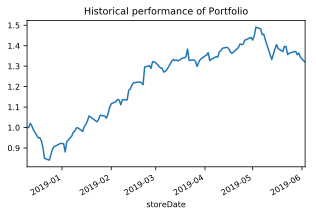

In [24]:
# index for predictions
get_ind_index(clean_px[symbols], tail=120, name='^PORT')['^PORT'].plot(
    title='Historical performance of Portfolio'
);

#### Descriptive stats

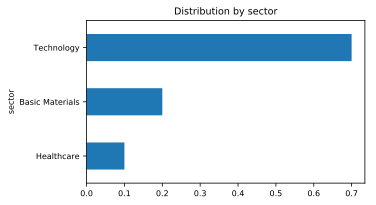

In [36]:
# Distribution by sector
by_sect = tech_ds.profile.loc[symbols].groupby(by=['sector'])\
    .count().iloc[:,0].sort_values()
(by_sect / by_sect.sum()).plot.barh(title='Distribution by sector');

In [37]:
# Distribution by industry
by_ind = tech_ds.profile.loc[symbols].groupby(by=['sector', 'industry'])\
    .count().iloc[:,0]
by_ind

sector           industry                           
Basic Materials  Chemicals                              1
                 Specialty Chemicals                    1
Healthcare       Medical Devices                        1
Technology       Information Technology Services        1
                 Semiconductor Equipment & Materials    1
                 Software - Application                 3
                 Software - Infrastructure              2
Name: address1, dtype: int64

In [38]:
# Most consistent predictions
if watch_overtime:
    port_selection = top_pos.sort_values(
        by=[('confidence', 'count'), ('confidence', 'mean')], 
        ascending=False)
else: port_selection = top_pos

Showing returns from DatetimeIndex(['2019-05-31', '2019-05-31'], dtype='datetime64[ns]', name='storeDate', freq=None)
Portfolio shape: (1, 11)


/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=737210.0, right=737210.0
  ax.set_xlim(left, right)


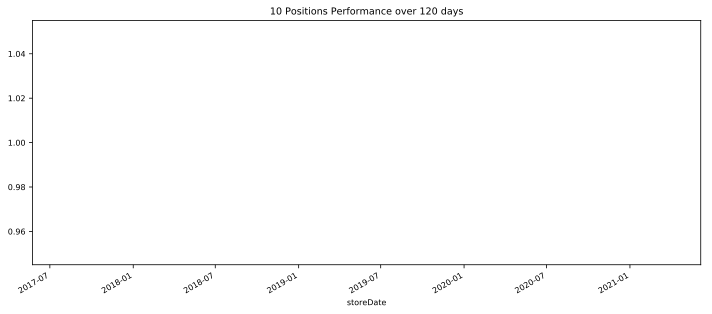

In [39]:
def stop_loss(df, long, max_loss):
    truth_df = (df < 1 - max_loss) if long else (df > 1 + max_loss)
    pos = truth_df[truth_df == True]
    if len(pos): df.loc[pos.index[0]:] = df.loc[pos.index[0]]
    return df

idx = tech_ds.clean_px.index.get_loc(study_dates[-1])
prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if loss_protection:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {tech_ds.clean_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')
port_index.plot(
    title=f'{nbr_positions} Positions Performance over {holding_period} days', 
    figsize=(12,5),
    alpha=0.5,
    legend=False);

Hit Rate: 0.0%


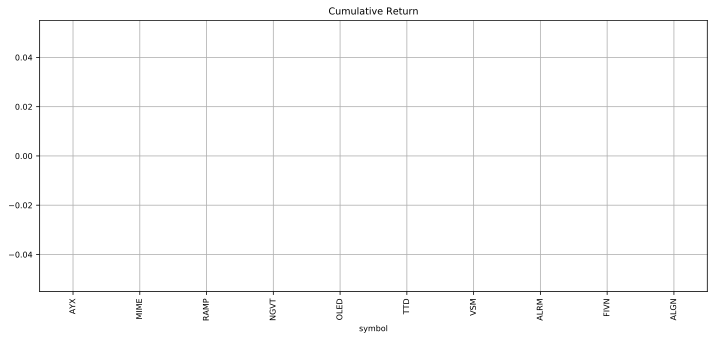

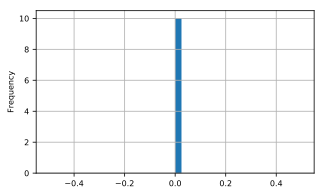

In [40]:
net_return = (port_index.iloc[-1, :-1] - 1)
hit_mask = net_return>0 if long else net_return<0
hit_rate = net_return.where(hit_mask).count() / net_return.count()
print(f'Hit Rate: {round(hit_rate*100, 1)}%')
net_return.sort_values().plot.bar(title='Cumulative Return', grid=True, figsize=(12,5)); plt.show()
net_return.plot.hist(bins=40, grid=True);

/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


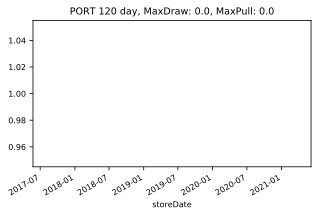

In [41]:
# cumulative returns for a given portfolio
max_d = round(TechnicalDS.max_draw(port_index.iloc[:, -1]), 2)
max_p = round(TechnicalDS.max_pull(port_index.iloc[:, -1]), 2)

port_index.iloc[:, -1].plot(
    title=f'PORT {holding_period} day, MaxDraw: {max_d}, MaxPull: {max_p}');

In [42]:
# cumulative returns for a given portfolio
port_index.iloc[-1, :-1].describe()

count   10.000
mean     1.000
std      0.000
min      1.000
25%      1.000
50%      1.000
75%      1.000
max      1.000
Name: 2019-05-31 00:00:00, dtype: float64

In [43]:
print(port_index.shape)
port_index.tail()

(1, 11)


symbol,AYX,MIME,RAMP,NGVT,OLED,TTD,VSM,ALRM,FIVN,ALGN,PORT
storeDate,,,,,,,,,,,
2019-05-31,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


### Backtesting multiple experiments

In [77]:
nbr_experiments = 500
describe_list = []; symbol_list = []; port_beg = []; port_end = []
profile, quotes = tech_ds.profile, tech_ds.quotes

In [70]:
# if running both long and short do nor re-run the indices to keep the same periods
mean_ret = pd.DataFrame()
pred_period_range = range(-study_period, pred_df.index.unique().shape[0] - holding_period)
start = np.random.choice(pred_period_range, size=1)
asofs_idx = np.unique([x for x in np.random.choice(pred_period_range, size=nbr_experiments)]) #random
# asofs_idx = [x for x in pred_period_range[:nbr_experiments]] # sequential
print(f'{len(asofs_idx)} Experiments')

472 Experiments


In [78]:
%%time

# What are the best portfolios and how do they perform?
for i, as_of_date in enumerate(asofs_idx):

    top_pred = get_top_predictions(pred_df, as_of_date, min_confidence)
    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    idx = tech_ds.clean_px.index.get_loc(study_dates[-1])

    if watch_overtime:    
        most_freq_df = get_most_frequent_preds(
            pred_df, study_dates, top_pred, pred_classes, period_tresh)
        top_pos = most_freq_df.head(nbr_positions)
    else:
        top_pos = top_pred.loc[
            top_pred.pred_class.isin(pred_classes) & 
            top_pred.confidence > min_confidence]\
            .head(nbr_positions)
    
    symbols = list(top_pos.symbol)

    if len(symbols) > 5:
        prices = tech_ds.clean_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        
        if loss_protection:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        
        net_return = (port_index.iloc[-1, :-1] - 1)
        hit_mask = net_return>0 if long else net_return<0
        hit_rate = net_return.where(hit_mask).count() / net_return.count()
        
        pos_beg = port_index.iloc[0, :-1]
        pos_end = port_index.iloc[-1, :-1]
        max_d = round(TechnicalDS.max_draw(port_index.iloc[:, -1]), 2)
        max_p = round(TechnicalDS.max_pull(port_index.iloc[:, -1]), 2)
        
        exp_describe = pos_end.describe()
        exp_describe['hit_rate'] = hit_rate
        exp_describe['max_draw'] = max_d
        exp_describe['max_pull'] = max_p
        exp_describe['offset_start'] = as_of_date
        exp_describe['as_of_date'] = str(study_dates[-1])
        exp_describe['study_period'] = study_period
        exp_describe['end_date'] = str(port_index.index[-1])
        
        port_beg.append(pos_beg)
        port_end.append(pos_end)
        symbol_list.append(symbols)
        describe_list.append(exp_describe)
    print(f'#{i+1}, {pred_df.index.unique()[asofs_idx][i]}')
    
portfolio_sel = pd.concat(port_beg, axis=1, sort=False).T
position_perf = pd.concat(port_end, axis=1, sort=False).T
hist_ports = pd.concat(describe_list, axis=1, sort=False).T
hist_ports = hist_ports.infer_objects()

#1, 2004-06-23 00:00:00
#2, 2004-07-07 00:00:00
#3, 2004-07-22 00:00:00
#4, 2004-09-09 00:00:00
#5, 2004-10-15 00:00:00
#6, 2004-10-22 00:00:00
#7, 2004-11-11 00:00:00
#8, 2004-12-22 00:00:00
#9, 2004-12-23 00:00:00
#10, 2004-12-28 00:00:00
#11, 2005-01-18 00:00:00
#12, 2005-01-19 00:00:00
#13, 2005-02-23 00:00:00
#14, 2005-03-07 00:00:00
#15, 2005-03-10 00:00:00
#16, 2005-03-11 00:00:00
#17, 2005-03-18 00:00:00
#18, 2005-03-22 00:00:00
#19, 2005-04-05 00:00:00
#20, 2005-04-14 00:00:00
#21, 2005-05-02 00:00:00
#22, 2005-05-18 00:00:00
#23, 2005-06-06 00:00:00
#24, 2005-06-20 00:00:00
#25, 2005-07-14 00:00:00
#26, 2005-08-03 00:00:00
#27, 2005-08-22 00:00:00
#28, 2005-08-30 00:00:00
#29, 2005-09-07 00:00:00
#30, 2005-09-16 00:00:00
#31, 2005-09-22 00:00:00
#32, 2005-09-23 00:00:00
#33, 2005-09-29 00:00:00
#34, 2005-10-11 00:00:00
#35, 2005-10-13 00:00:00
#36, 2005-10-17 00:00:00
#37, 2005-10-18 00:00:00
#38, 2005-10-31 00:00:00
#39, 2005-11-04 00:00:00
#40, 2005-12-01 00:00:00
#41, 2005

#321, 2014-03-17 00:00:00
#322, 2014-03-21 00:00:00
#323, 2014-03-28 00:00:00
#324, 2014-04-17 00:00:00
#325, 2014-04-22 00:00:00
#326, 2014-05-16 00:00:00
#327, 2014-06-20 00:00:00
#328, 2014-07-08 00:00:00
#329, 2014-08-11 00:00:00
#330, 2014-08-21 00:00:00
#331, 2014-08-26 00:00:00
#332, 2014-09-18 00:00:00
#333, 2014-09-23 00:00:00
#334, 2014-10-02 00:00:00
#335, 2014-10-03 00:00:00
#336, 2014-10-22 00:00:00
#337, 2014-10-24 00:00:00
#338, 2014-11-12 00:00:00
#339, 2014-11-26 00:00:00
#340, 2014-12-01 00:00:00
#341, 2014-12-04 00:00:00
#342, 2014-12-10 00:00:00
#343, 2014-12-23 00:00:00
#344, 2014-12-30 00:00:00
#345, 2015-01-06 00:00:00
#346, 2015-01-16 00:00:00
#347, 2015-02-05 00:00:00
#348, 2015-02-19 00:00:00
#349, 2015-02-23 00:00:00
#350, 2015-02-24 00:00:00
#351, 2015-02-25 00:00:00
#352, 2015-02-26 00:00:00
#353, 2015-03-26 00:00:00
#354, 2015-04-08 00:00:00
#355, 2015-04-14 00:00:00
#356, 2015-04-15 00:00:00
#357, 2015-04-16 00:00:00
#358, 2015-05-13 00:00:00
#359, 2015-0

In [79]:
print(f'Summary for {len(asofs_idx)} unique {"LONG" if long else "SHORT"} experiments')
print(f'{len(position_perf.columns.unique())} unique symbols (from different portfolios)')

Summary for 472 unique SHORT experiments
649 unique symbols (from different portfolios)


In [80]:
grand_summary = hist_ports.describe().loc['mean']
cagr = round(grand_summary['mean'] ** (1/(holding_period/252)) - 1, 2)
print(f'CAGR: {cagr}')
grand_summary

CAGR: -0.3


count              9.998
mean               0.845
std                0.110
min                0.645
25%                0.789
50%                0.858
75%                0.915
max                0.992
hit_rate           0.933
max_draw          -0.219
max_pull           0.108
offset_start   1,930.405
study_period     -10.000
Name: mean, dtype: float64

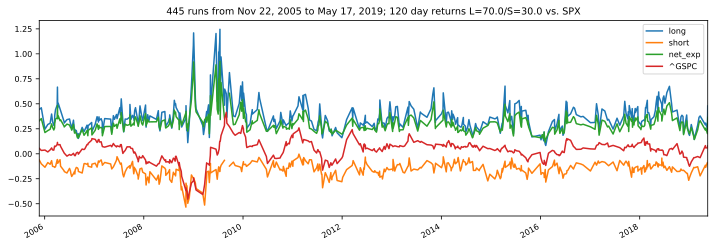

In [81]:
# historical performance chart
l_w = 0.7
bench = '^GSPC'

if long: mean_ret['long'] = hist_ports['mean'].copy() - 1
elif not long: mean_ret['short'] = hist_ports['mean'].copy() - 1

if 'long' in mean_ret.columns and 'short' in mean_ret.columns:
    mean_ret['net_exp'] = (mean_ret['long']) * l_w - (mean_ret['short']) * (1-l_w)
    from_dt, to_dt = list(mean_ret.index[[0,-1]])
    from_dt = from_dt.strftime('%b %d, %Y')
    to_dt = to_dt.strftime('%b %d, %Y')
    
    SPX_df = clean_px['^GSPC']
    SPX_df = SPX_df.pct_change(look_ahead).to_frame()
    mean_ret[bench] = SPX_df.loc[mean_ret.index.unique()]
    
    ax = mean_ret.plot(
        title=f'{mean_ret.shape[0]} runs from {from_dt} to {to_dt}; {holding_period} day returns L={l_w*100}/S={round(1-l_w, 1)*100} vs. SPX',
        figsize=(12,4), 
#         ylim=(-.5, .5)
    );

In [82]:
mean_ret.describe(percentiles=[0.05, .5,0.95])

,long,short,net_exp,^GSPC
count,445.000,442.000,442.000,445.000
mean,0.375,-0.152,0.308,0.034
std,0.152,0.072,0.104,0.108
min,0.083,-0.533,0.116,-0.454
5%,0.195,-0.277,0.192,-0.116
50%,0.348,-0.142,0.289,0.051
95%,0.606,-0.061,0.447,0.171
max,1.245,-0.004,0.925,0.415


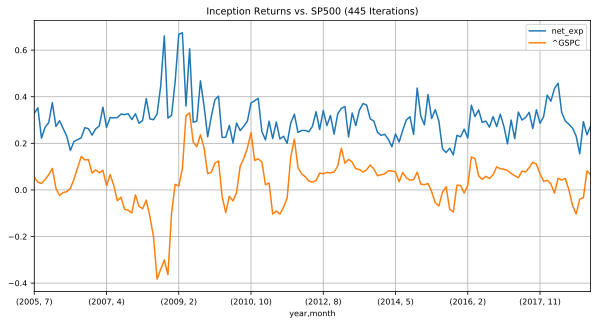

In [96]:
from datetime import date, timedelta
show_cols = ['net_exp', bench]
df = mean_ret[show_cols].copy()
df.index = pd.to_datetime(df.index.date - timedelta(holding_period))
df['year'] = df.index.year
df['month'] = df.index.month
group_ret_df = df.groupby(by=['year', 'month']).mean()
group_ret_df.plot(
    title=f'Inception Returns vs. SP500 ({len(mean_ret.index)} Iterations)',
    figsize=(10,5),
    grid=True);

#### Descriptive stats

In [1529]:
perf_col = f'perfAttrib{holding_period}D'
pos_attribution = position_perf.mean()
uniq_pos_perf = pos_attribution.to_frame()
uniq_pos_perf.columns = [perf_col]
uniq_pos_perf['name'] = quotes.loc[uniq_pos_perf.index, ['shortName']]
uniq_pos_perf[['sector', 'industry']] = profile.loc[uniq_pos_perf.index, ['sector', 'industry']]

In [1530]:
# top ten attribution
# top10_attrib = uniq_pos_perf.sort_values(by=perf_col, ascending=False).head()
# top10_attrib

In [1531]:
# bottom ten attribution
# uniq_pos_perf.sort_values(by=perf_col, ascending=False).tail()

In [1532]:
perf_sector = uniq_pos_perf.groupby(by=['sector']).agg(['mean', 'count'])
perf_ind = uniq_pos_perf.groupby(by=['industry']).mean().sort_values(by=perf_col) - 1

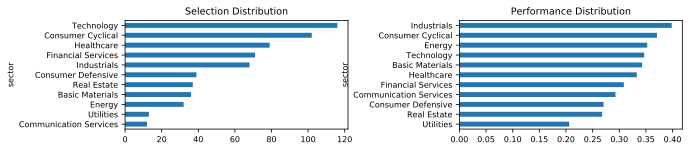

In [1533]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
perf_sector[(perf_col, 'count')].sort_values().plot.barh(title='Selection Distribution', ax=axes[0]);
(perf_sector[(perf_col, 'mean')].sort_values() - 1).plot.barh(title='Performance Distribution', ax=axes[1]);

In [1534]:
# Distribution by industry
by_ind = uniq_pos_perf.groupby(by=['sector', 'industry']).count().iloc[:,0].sort_values(ascending=False)
by_ind.head(20)

sector                  industry                      
Technology              Software - Application            28
Financial Services      Banks - Regional - US             25
Healthcare              Biotechnology                     17
Energy                  Oil & Gas E&P                     15
Consumer Cyclical       Specialty Retail                  15
Technology              Semiconductors                    13
Healthcare              Medical Instruments & Supplies    13
                        Diagnostics & Research            13
Industrials             Business Services                 12
Consumer Defensive      Packaged Foods                    12
Basic Materials         Specialty Chemicals               11
Technology              Internet Content & Information    11
Financial Services      Asset Management                  10
Consumer Cyclical       Restaurants                       10
Technology              Communication Equipment            9
Consumer Cyclical       Media 

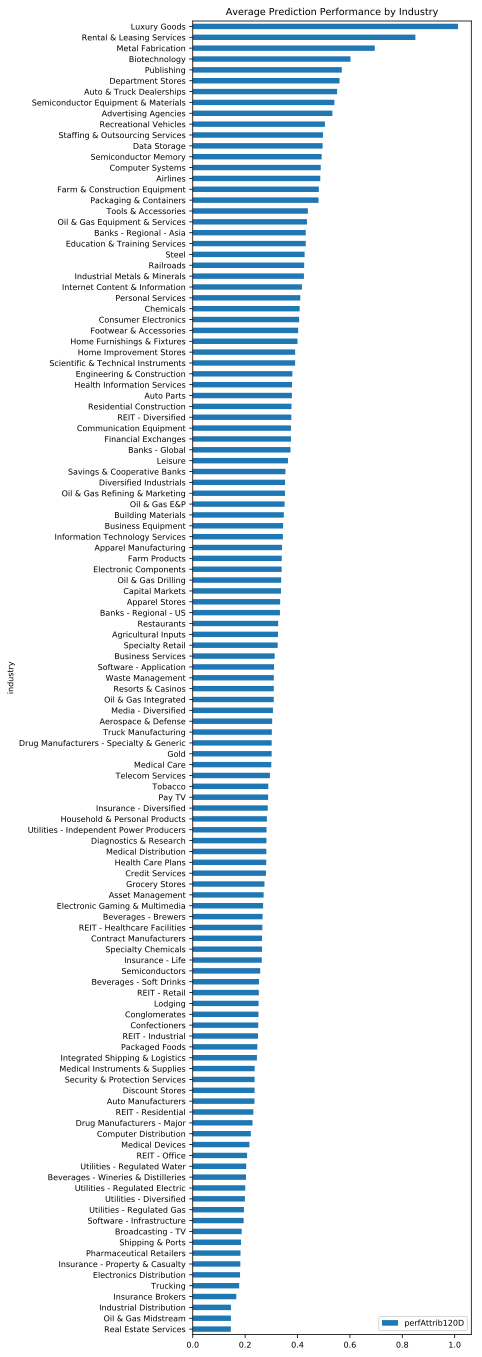

In [1535]:
fsize = (5, len(perf_ind.index) / 25 * 5)
perf_ind.plot.barh(title='Average Prediction Performance by Industry', figsize=fsize);

In [1536]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

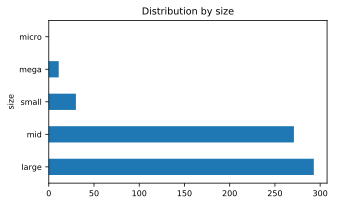

In [1537]:
unique_symbols = list(uniq_pos_perf.index.unique())
size_df = tech_ds.quotes.loc[unique_symbols, ['marketCap']] / 10**9
size_df['size'] = discret_rets(size_df.marketCap, mkt_cap_cuts, mkt_cap_labels)
size_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.barh(title='Distribution by size');

#### Most frequent

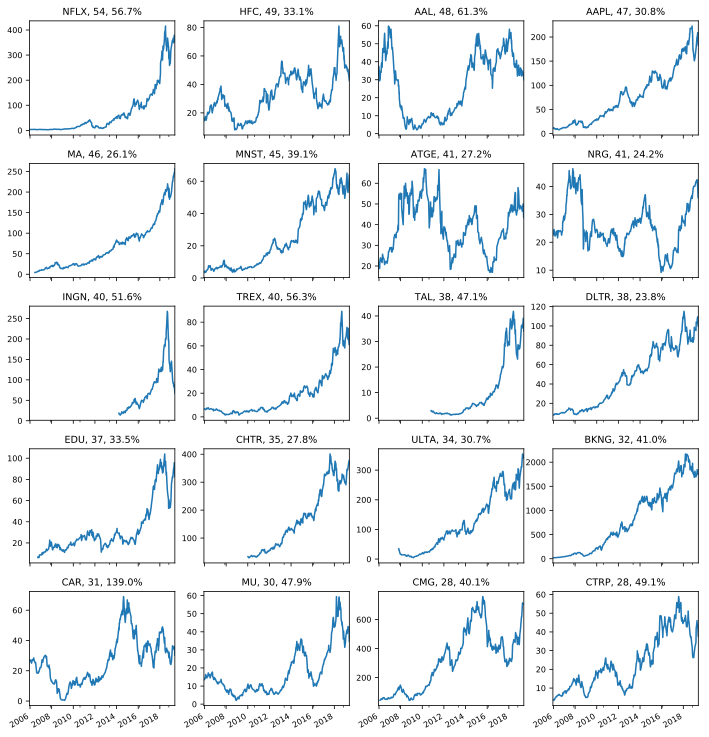

In [678]:
# Most common recommendations with realized performance
most_frequent = position_perf.count(axis=0).sort_values(ascending=False).head(20)
plot_df = most_frequent

lens = len(plot_df.index); cols = 4; rows = lens // cols
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 14), sharex=True)
plt.subplots_adjust(hspace=0.25)

for i, t in enumerate(zip(most_frequent.index, most_frequent.values)):
    row = i // cols; col = i - cols * row
    avg_return = round((pos_attribution[t[0]]-1) * 100, 1)
    clean_px[t[0]].loc[position_perf.index].plot(
        title=f'{t[0]}, {t[1]}, {avg_return}%',
        ax=axes[row, col])

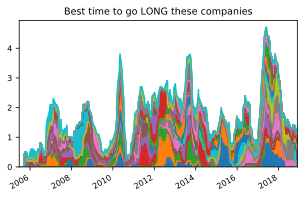

In [679]:
# how often are companies in the predictions?
df = portfolio_sel.sort_index().where(~portfolio_sel.isna(), 0)
# percentage of the time within a 30 day period that a company is recommended
likely_df = (df.rolling(-study_period).sum() / -study_period)

title = f'Best time to go {"LONG" if long else "SHORT"} these companies'
# symbols = ['NFLX', 'CRM', 'BLUE', 'TSLA']
# symbols = np.random.choice(likely_df.columns, size=10)
symbols = list(most_frequent.index)
likely_df[symbols].plot.area(title=title, legend=False); # mix of predictions is different everyday

# most_freq = likely_df.mean().sort_values().tail(10).index # most frequent
# df[symbols].plot.area();

,count,mean,std,min,25%,50%,75%,max
count,20.000,20.000,20.000,20.000,20.000,20.000,20.000,20.000
mean,134.850,0.293,0.198,0.100,0.115,0.237,0.401,0.835
std,25.056,0.060,0.048,0.000,0.037,0.063,0.130,0.173
min,85.000,0.189,0.117,0.100,0.100,0.150,0.200,0.500
25%,131.000,0.263,0.168,0.100,0.100,0.200,0.300,0.700
50%,137.000,0.276,0.202,0.100,0.100,0.200,0.400,0.900
75%,148.500,0.334,0.232,0.100,0.100,0.300,0.500,1.000
max,177.000,0.455,0.293,0.100,0.200,0.400,0.800,1.000


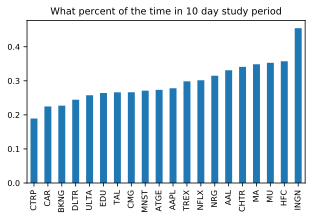

In [680]:
pct_study_period = likely_df[symbols].apply(lambda x: x.where(x>0))
pct_study_period.mean().sort_values().plot.bar(
    title=f'What percent of the time in {-study_period} day study period');
pct_study_period.describe().T.describe()

#### Portfolio metrics

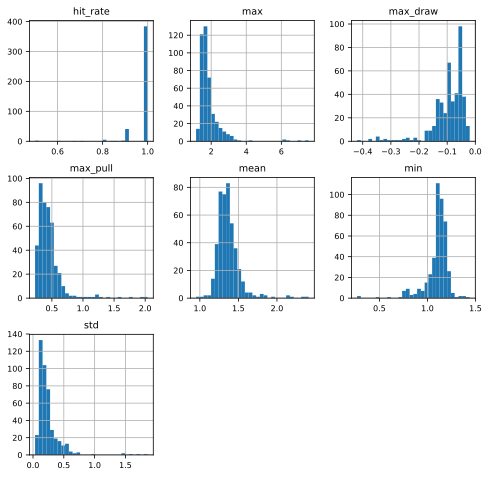

In [681]:
# relationship among position count, returns and risk
from pandas.plotting import scatter_matrix
show_cols = ['mean', 'std', 'min', 'max', 'hit_rate', 'max_draw', 'max_pull']
# scatter_matrix(
#     hist_ports[show_cols], 
#     figsize=(10,10));

hist_ports[show_cols].hist(bins=30, figsize=(8,8));
# hist_ports[show_cols].boxplot()

In [424]:
##### full detail for all experiments
hist_ports.sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max,hit_rate,max_draw,max_pull,offset_start,as_of_date,study_period,end_date
2010-01-29,10.000,0.753,0.108,0.564,0.699,0.782,0.826,0.878,1.000,-0.260,0.120,57.000,2009-08-10 00:00:00,-10,2010-01-29 00:00:00
2009-11-19,10.000,0.771,0.191,0.268,0.776,0.837,0.862,0.929,1.000,-0.240,0.100,10.000,2009-06-03 00:00:00,-10,2009-11-19 00:00:00
2010-01-28,10.000,0.777,0.123,0.594,0.682,0.797,0.886,0.914,1.000,-0.260,0.100,56.000,2009-08-07 00:00:00,-10,2010-01-28 00:00:00
2009-12-18,10.000,0.796,0.149,0.522,0.715,0.790,0.913,1.013,0.900,-0.300,0.190,30.000,2009-07-01 00:00:00,-10,2009-12-18 00:00:00
2010-01-22,10.000,0.802,0.131,0.584,0.700,0.832,0.895,0.988,1.000,-0.290,0.100,52.000,2009-08-03 00:00:00,-10,2010-01-22 00:00:00
2010-02-02,10.000,0.806,0.096,0.562,0.786,0.823,0.855,0.921,1.000,-0.240,0.140,59.000,2009-08-12 00:00:00,-10,2010-02-02 00:00:00
2010-01-26,10.000,0.809,0.123,0.577,0.753,0.844,0.878,0.988,1.000,-0.270,0.120,54.000,2009-08-05 00:00:00,-10,2010-01-26 00:00:00
2009-12-22,10.000,0.811,0.168,0.540,0.718,0.787,0.903,1.102,0.800,-0.330,0.310,32.000,2009-07-06 00:00:00,-10,2009-12-22 00:00:00
2010-01-25,10.000,0.816,0.113,0.564,0.776,0.844,0.866,0.960,1.000,-0.270,0.110,53.000,2009-08-04 00:00:00,-10,2010-01-25 00:00:00
2010-02-01,10.000,0.817,0.122,0.598,0.794,0.855,0.860,0.990,1.000,-0.230,0.110,58.000,2009-08-11 00:00:00,-10,2010-02-01 00:00:00


#### Accuracy of predictions

In [624]:
cut_range = tech_ds.return_intervals()
pred_class_tresh = [cut_range[1], cut_range[2], 0, cut_range[3], cut_range[4]]
actual_gt_tresh = lambda x, y: x > y if x > 0 else x < y
right_direction = lambda x, y: x > 0 if x > 0 else x < 0

def hist_company_accuracy(symbol, pred_df, min_confidence, clean_px, pred_class_tresh, fn):
    co_pred = pred_df.loc[(pred_df.symbol.isin([symbol]) & pred_df.confidence > min_confidence), :]
    if len(co_pred) > 0 and t in clean_px.columns:
        fwd_return = clean_px[symbol].pct_change(look_ahead).shift(-look_ahead).loc[co_pred.index]
        if len(fwd_return.dropna()) > 0:
            pred_comparison = pd.concat([fwd_return, co_pred.pred_class.apply(lambda x: pred_class_tresh[x])], axis=1).dropna()
            count = pd.value_counts(pred_comparison.apply(lambda x: fn(x[0], x[1]), axis=1))
            return symbol, (count[True] / count.sum() if True in count else 0)

Treshold distributions: [ -inf -0.19 -0.1   0.13  0.24   inf]


In [627]:
symbol = 'ADBE'
hist_company_accuracy(symbol, pred_df, 0.90, clean_px, cut_range, right_direction)

('ADBE', 1.0)

In [ ]:
%%time
super_list = []
for t in np.random.choice(tech_ds.tickers, size=50):
    res = hist_company_accuracy(t, pred_df, 0.9, clean_px, cut_range, actual_gt_tresh)
    super_list.append(res)
    print(res)

In [632]:
# of the time actual returns is in the same direction as the predicted class
unpacked = list(zip(*[x for x in super_list if x is not None]))
average_score = (pd.Series(unpacked[1], index=unpacked[0]).mean())
print(f'%0.2f percent actual returns are in the same direction as the predicted class' % average_score * 100)

99.90


In [635]:
unpacked = list(zip(*[x for x in super_list if x is not None]))
# of the time actual returns is above the treshold for the class
average_score = (pd.Series(unpacked[1], index=unpacked[0]).mean())
print(f'%0.2f percent actual returns are in excess of predicted class (outpeform)' % average_score * 100)

42.89


#### L/S portfolio weights

In [1128]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long']).mul(l_w) - 
        (mean_ret['short']).mul(1 - l_w))
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

In [1139]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
if 'short' in mean_ret.columns:
    for l_w in series:
        monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
        super_list.append(mix_df)
#         monthly_ret.cumprod().plot()
    scenarios = pd.concat(super_list, axis=1).T
    opt_wgt = series[np.argmax(scenarios['mean'] / scenarios['std'])]
    
    # expected long-term return at optimal L/S mix
    monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
#     print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
#     monthly_ret.cumprod().plot();

Optimal allocation (0.55, 0.44999999999999996)


,count,mean,std,min,25%,50%,75%,max,l,s
0,45.000,0.240,0.052,0.147,0.213,0.240,0.265,0.389,0.400,0.600
1,45.000,0.250,0.051,0.159,0.219,0.249,0.281,0.394,0.450,0.550
2,45.000,0.260,0.052,0.169,0.222,0.262,0.294,0.400,0.500,0.500
3,45.000,0.270,0.054,0.176,0.224,0.277,0.307,0.405,0.550,0.450
4,45.000,0.280,0.057,0.183,0.231,0.283,0.321,0.411,0.600,0.400
5,45.000,0.290,0.060,0.190,0.240,0.295,0.336,0.417,0.650,0.350
6,45.000,0.301,0.065,0.197,0.242,0.300,0.348,0.422,0.700,0.300
7,45.000,0.311,0.070,0.204,0.248,0.314,0.364,0.437,0.750,0.250
8,45.000,0.321,0.076,0.188,0.254,0.320,0.379,0.463,0.800,0.200
9,45.000,0.331,0.082,0.169,0.255,0.326,0.393,0.490,0.850,0.150


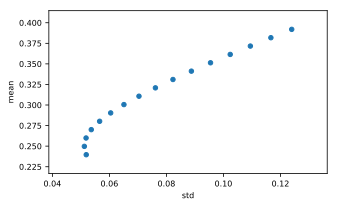

In [1149]:
scenarios[['mean', 'std']].plot(kind='scatter', x='std', y='mean')
print(f'Optimal allocation {opt_wgt, 1 - opt_wgt}')
scenarios